In [79]:
import pandas as pd
import numpy as np
import itertools
from functools import partial
from typing import Callable, List

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown

In [81]:
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import kstest, expon, lognorm, weibull_min, gamma
from scipy.stats.mstats import winsorize
from scipy.stats import pearsonr

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [83]:
from sklearn.preprocessing import MinMaxScaler

In [84]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [85]:
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold, StratifiedKFold, LeavePOut
from keras import regularizers
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from keras.preprocessing.sequence import TimeseriesGenerator

# Supervised Hybrid Production-Level Long Short Term Memory Recurrent Neural Network:
#### _Semi-Automating proccesses for building and optimization_

## Forecasting Absolute Humidity

### Question: Can we predict humidity in San Diego for the next day based on a given humidity, wind speed, wind direction, and pressure for that hour?

An LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is designed to handle long-term dependencies in sequential data. It uses a memory cell that can store information for long periods of time and a set of gates to control the flow of information into and out of the cell. The gates are used to selectively forget or remember information based on the input and the current state of the cell. LSTMs have been shown to be effective in a wide range of applications including natural language processing, speech recognition, and time series prediction.
The chosen model is a recurrent neural network (RNN) with long short-term memory (LSTM) cells. The reason for this choice is that LSTMs are specifically designed for handling time-series data, which makes them well-suited for forecasting tasks. 
LSTMs have the ability to learn long-term dependencies in the data, which is important for capturing the patterns and trends that may exist in the time-series data. Additionally, LSTMs are capable of handling sequential data of varying lengths, which is useful for this problem since the number of time steps in the input data may vary. LSTMs are often preferred for time-series forecasting problems due to their ability to capture long-term dependencies and their flexibility in handling sequential data.

## 1. Data

In [86]:
city_att= pd.read_csv('C:/Users/calve/Documents/SrPowerSystemsForecasterSpecialist/clean_data/cleaned_cities.csv')

In [87]:
humidity= pd.read_csv('C:/Users/calve/Documents/SrPowerSystemsForecasterSpecialist/clean_data/cleaned_humidity.csv')

In [88]:
pressure= pd.read_csv('C:/Users/calve/Documents/SrPowerSystemsForecasterSpecialist/clean_data/cleaned_pressure.csv')

In [89]:
wind_speed= pd.read_csv('C:/Users/calve/Documents/SrPowerSystemsForecasterSpecialist/clean_data/cleaned_ws.csv')

In [90]:
wind_dir= pd.read_csv('C:/Users/calve/Documents/SrPowerSystemsForecasterSpecialist/clean_data/cleaned_wr.csv')

In [91]:
# Rename the columns in the original DataFrames
humidity.columns = [f'humidity_{col}' for col in humidity.columns]
pressure.columns = [f'pressure_{col}' for col in pressure.columns]
wind_dir.columns = [f'wind_dir_{col}' for col in wind_dir.columns]
wind_speed.columns = [f'wind_speed_{col}' for col in wind_speed.columns]

In [92]:
# Concatenate the DataFrames along the columns axis
san_diego_df = pd.concat([humidity[['humidity_datetime']], humidity.drop('humidity_datetime', axis=1), pressure, wind_dir, wind_speed], axis=1)

san_diego_columns = ['humidity_datetime'] + [col for col in san_diego_df.columns if 'San Diego' in col]
san_diego_df = san_diego_df[san_diego_columns]

In [93]:
san_diego_df.columns

Index(['humidity_datetime', 'humidity_San Diego', 'pressure_San Diego',
       'wind_dir_San Diego', 'wind_speed_San Diego'],
      dtype='object')

In [94]:
#Rename the columns
san_diego_df= san_diego_df.rename(columns={"humidity_datetime": "datetime", "humidity_San Diego": "humidity", "pressure_San Diego":"pressure", "wind_dir_San Diego":"wind_dir", "wind_speed_San Diego": "wind_speed"})

In [95]:
san_diego_df.columns

Index(['datetime', 'humidity', 'pressure', 'wind_dir', 'wind_speed'], dtype='object')

In [96]:
#Extract the hour from the datetime column
san_diego_df['hour'] = pd.to_datetime(san_diego_df['datetime']).dt.hour

In [97]:
#Drop datetime
san_diego_df.drop(['datetime'], inplace= True, axis= 1)

In [98]:
san_diego_df

,humidity,pressure,wind_dir,wind_speed,hour
0,82.0,1013.0,0.0,0.0,13
1,81.0,1013.0,0.0,0.0,14
2,81.0,1013.0,0.0,0.0,15
3,81.0,1013.0,0.0,0.0,16
4,80.0,1013.0,0.0,0.0,17
...,...,...,...,...,...
44455,60.0,1015.0,320.0,3.0,20
44456,64.0,1013.0,300.0,3.0,21
44457,60.0,1013.0,330.0,3.0,22
44458,44.0,1012.0,300.0,4.0,23


In [99]:
#Determine Distribution

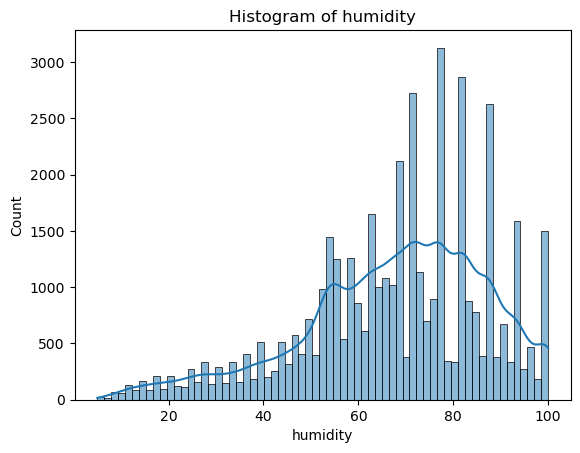

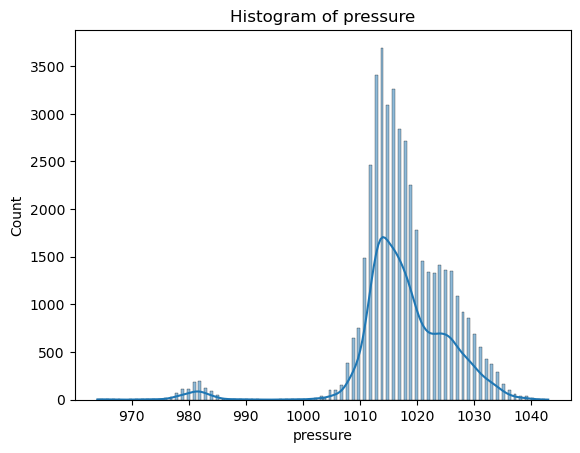

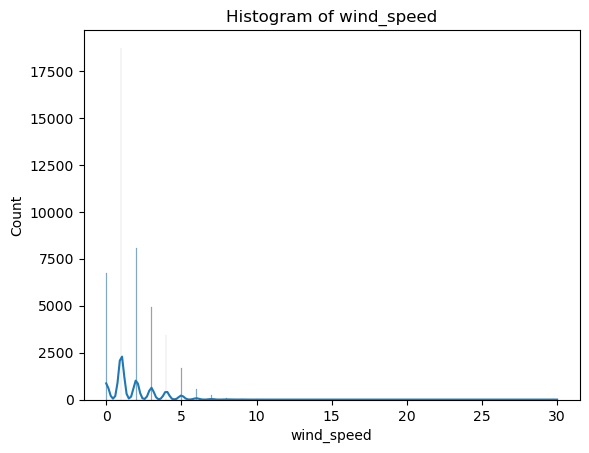

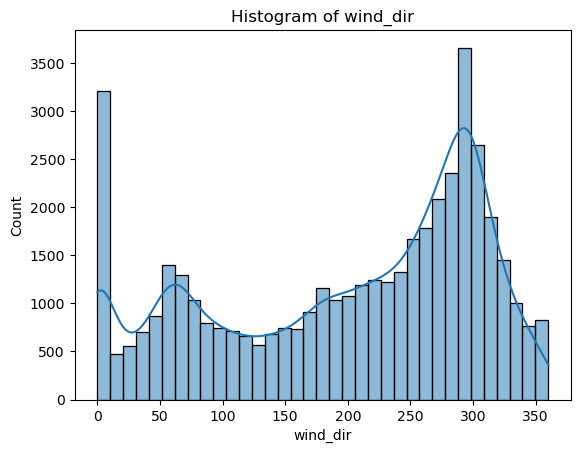

In [100]:
#Plotting the data with histograms to see patterns
weather_elements = ['humidity', 'pressure', 'wind_speed', 'wind_dir']
for element in weather_elements:
    plt.figure()
    sns.histplot(data=san_diego_df, x=element, kde=True)
    plt.title(f'Histogram of {element}')
    plt.show()

In [101]:
#Calcutlating statistics for the columns to examine outliers and distribution
for element in weather_elements:
    mean = san_diego_df[element].mean()
    median = san_diego_df[element].median()
    std_dev = san_diego_df[element].std()
    print(f'{element}: Mean={mean}, Median={median}, Standard Deviation={std_dev}')

humidity: Mean=67.74769363283995, Median=71.0, Standard Deviation=19.445948262825503
pressure: Mean=1017.5459061554442, Median=1017.0, Standard Deviation=8.622522074894706
wind_speed: Mean=1.7515969410706254, Median=1.0, Standard Deviation=1.4918345918914822
wind_dir: Mean=199.21417004048584, Median=230.0, Standard Deviation=106.13016777543389


<Figure size 640x480 with 0 Axes>

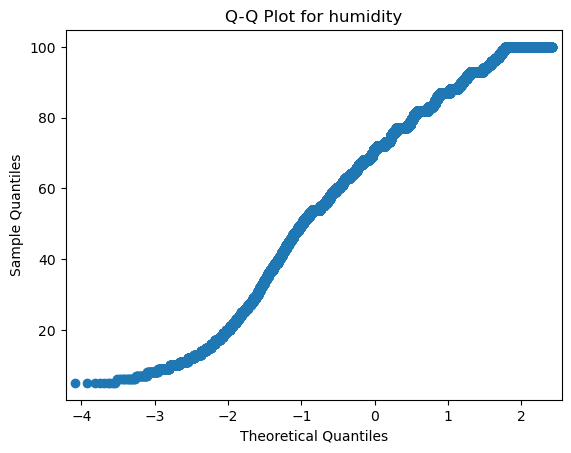

<Figure size 640x480 with 0 Axes>

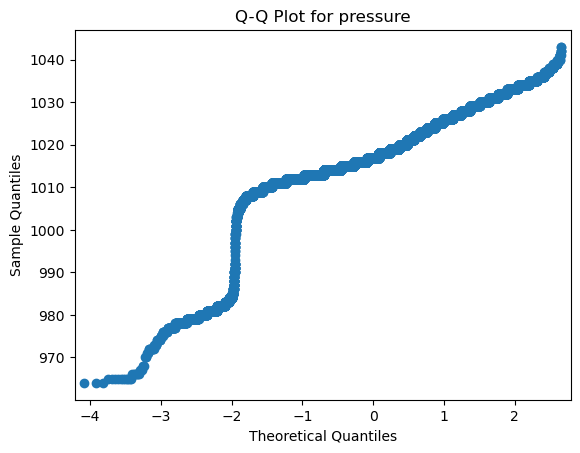

<Figure size 640x480 with 0 Axes>

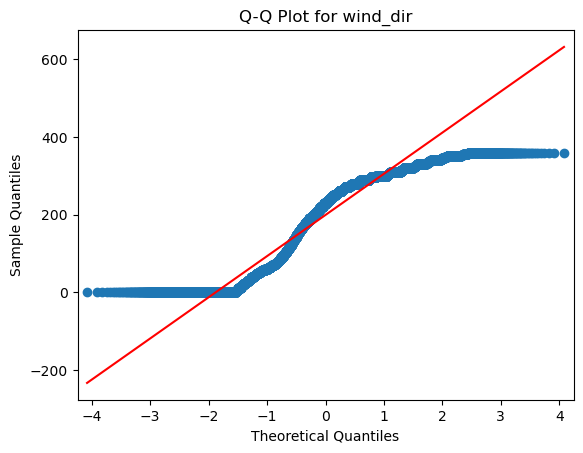

<Figure size 640x480 with 0 Axes>

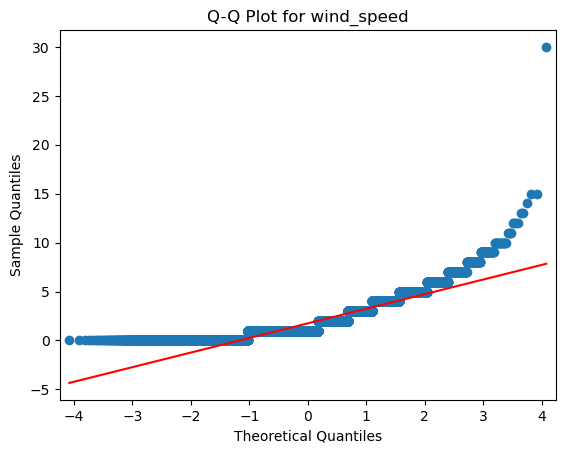

<Figure size 640x480 with 0 Axes>

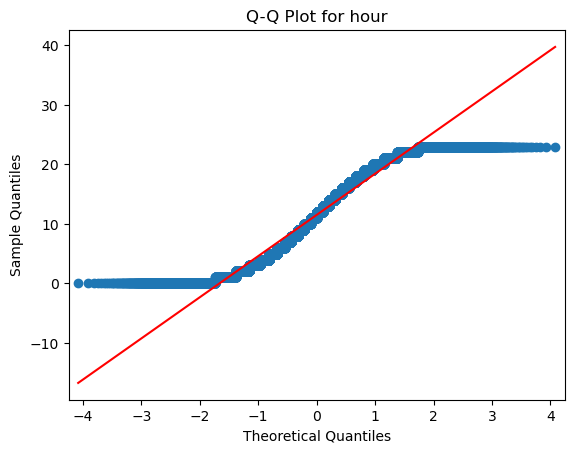

In [102]:
#QQ Plots to investigate distribution further
for element in san_diego_df:
    plt.figure()
    sm.qqplot(san_diego_df[element], line='s')
    plt.title(f'Q-Q Plot for {element}')
    plt.show()

In [103]:
'''The purpose of the quantile-quantile (QQ) plot is to show if two data sets come from the same distribution.- Yunsi Wang, Tyler Steele, Eva Zhang
https://math.illinois.edu/system/files/inline-files/Proj9AY1516-report2.pdf'''

'The purpose of the quantile-quantile (QQ) plot is to show if two data sets come from the same distribution.- Yunsi Wang, Tyler Steele, Eva Zhang\nhttps://math.illinois.edu/system/files/inline-files/Proj9AY1516-report2.pdf'

In [104]:
#Creating a function to use statistcal tests to determine distribution
weather_elements = ['humidity', 'pressure', 'wind_speed', 'wind_dir']

san_diego_df = san_diego_df.applymap(lambda x: x if np.isfinite(x) else np.nan)

def test_distributions(series):
    
    
    series = series[np.isfinite(series)]
    
    distributions = {
        "normal": stats.norm,
        "exponential": stats.expon,
        "logistic": stats.logistic
    }
    
    results = {}
    for dist_name, dist in distributions.items():
        params = dist.fit(series)
        D, p = stats.kstest(series, dist.cdf, args=params)
        results[dist_name] = (D, p)
    
    return results

for element in weather_elements:
    print(f"{element} distribution:")
    results = test_distributions(san_diego_df[element])
    for dist_name, (D, p) in results.items():
        print(f"{dist_name}: D={D}, p-value={p}")
    print()

humidity distribution:
normal: D=0.07225708153364296, p-value=9.521463621270879e-201
exponential: D=0.3549962526547573, p-value=0.0
logistic: D=0.0565723130142094, p-value=3.622505804104062e-123

pressure distribution:
normal: D=0.14996863978091823, p-value=0.0
exponential: D=0.5242211365851986, p-value=0.0
logistic: D=0.09150311488892317, p-value=0.0

wind_speed distribution:
normal: D=0.26540812964324156, p-value=0.0
exponential: D=0.2836830540579809, p-value=0.0
logistic: D=0.24111324355792074, p-value=0.0

wind_dir distribution:
normal: D=0.13003959649634, p-value=0.0
exponential: D=0.22719236582053187, p-value=0.0
logistic: D=0.10435693010217906, p-value=0.0



In [105]:
#Asid from obviously hour, there doesn't seem to be any pattern of distribution that I can identify at the moment

## 2. Feature Engineering and Preprocessing:

In [106]:
san_diego_df.isnull().any(axis=1).sum()

353

In [107]:
#Dropping Nulls
san_diego_df = san_diego_df.dropna() 

In [108]:
san_diego_df.shape

(44107, 5)

In [109]:
#Making a column for my target
san_diego_df['next_day_humidity'] = san_diego_df['humidity'].shift(-24)

In [110]:
san_diego_df.columns

Index(['humidity', 'pressure', 'wind_dir', 'wind_speed', 'hour',
       'next_day_humidity'],
      dtype='object')

In [111]:
#Identifying and quantifying outliers

In [112]:
def detect_outliers_zscore(df, threshold=3):
    outliers = pd.DataFrame()
    for col in df.columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outliers_col = df[z_scores > threshold][col]
        outliers_col.name = col
        outliers = pd.concat([outliers, outliers_col], axis=1)
    return outliers

In [113]:
def get_outlier_list(df, threshold):
    outlier_list = {}
    outlier = detect_outliers_zscore(df, threshold)
    for col in outlier.columns:
        non_null_mask = outlier[col].notnull()
        if non_null_mask.any():
            outlier_list[col] = outlier.loc[non_null_mask, col].values.tolist()
    
    return outlier_list

In [114]:
outliers= get_outlier_list(san_diego_df, threshold= 3)

In [115]:
for element, values in outliers.items():
    print(f"{element}: {len(values)}")

humidity: 113
pressure: 1127
wind_speed: 363
next_day_humidity: 113


In [116]:
#A small amount of outliers for the given data set- moderation is not necessary

Applying the Winsorize method to moderate outliers as a display of proficiency in selecting and applying statistical models and best data practices
Reasons for Selection: 
1. No normal distribution 
2. To maintain data integrity by only removing the extreme outliers- Extreme outliers might indicate faulty data

https://www.statisticshowto.com/winsorize/

In [117]:
#Defining percentile to drop
percentiles = [0.01, 0.99]

In [118]:
#Iterating the method over each feature
for col in weather_elements:
    san_diego_df[col] = winsorize(san_diego_df[col], limits=percentiles)

In [119]:
#Encoding catergorical variables

In [120]:
# Circular encoding for wind direction
san_diego_df['wind_dir_sin'] = np.sin(2*np.pi*san_diego_df['wind_dir']/360)
san_diego_df['wind_dir_cos'] = np.cos(2*np.pi*san_diego_df['wind_dir']/360)

In [121]:
# Drop the original wind_direction column
san_diego_df.drop('wind_dir', axis=1, inplace=True)

In [122]:
#One Hot Encoding 'hour'
#Get the dummies for hour
one_hot = pd.get_dummies(san_diego_df["hour"], prefix="hour")
#Concat the dummy column
san_diego_df = pd.concat([san_diego_df, one_hot], axis=1)

In [123]:
#Dropping original hour
san_diego_df.drop("hour", axis=1, inplace=True)

In [124]:
#Engineering Features

In [139]:
#Capturing the temporal relationship between the current and previous hour's humidity values
san_diego_df['prev_hour_humidity'] = san_diego_df['humidity'].shift(1)

seasonal_decompose() is a function from the statsmodels library that decomposes a time series into its trend, seasonality, and residual components. The resulting components can help identify patterns and relationships in the time series data that may not be easily observable in the raw data

In [126]:
result = seasonal_decompose(san_diego_df['humidity'], model='additive', period=24)

In [127]:
#long-term trend in the humidity data
san_diego_df['humidity_trend'] = result.trend
#recurring seasonal patterns
san_diego_df['humidity_seasonality'] = result.seasonal
# unexplained variance or randomness
san_diego_df['humidity_residual'] = result.resid

In [128]:
san_diego_df.columns

Index(['humidity', 'pressure', 'wind_speed', 'next_day_humidity',
       'wind_dir_sin', 'wind_dir_cos', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'prev_hour_humidity', 'humidity_trend',
       'humidity_seasonality', 'humidity_residual'],
      dtype='object')

In [130]:
#Seperating Features and Target into X and y
X = san_diego_df.drop('next_day_humidity', axis=1)
y = san_diego_df[['next_day_humidity']]

In [131]:
#Initializing Scaler
scaler = MinMaxScaler() #Min Max chosen due to limited outliers

In [132]:
#Transforming our Features
X_scaled = scaler.fit_transform(X)

## 3. Model Building:

### Semi-Automatically Determing the Best Build

### Starting from here the the _Manually Assigning Values_ section the order of the cells were altered for readability and presentation purposes. Execution order is indicated in the upper right corner of the cell containing the code.

#### build(X, y, hyperparameters_list, cv_methods, input_steps, output_steps, feature_selection_funcs=feature_selection_funcs(), metric=calculate_metric):
  
Arguments:

* X: numpy array, input features of shape (n_samples, n_features).
* y: numpy array, output targets of shape (n_samples,).
* hyperparameters_list: list of dictionaries, each containing hyperparameters for the LSTM model.
* cv_methods: dictionary, containing cross-validation methods to use.
input_steps: int, number of input steps for LSTM.
output_steps: int, number of output steps for LSTM.
feature_selection_funcs: list of functions, each function performs a different feature selection technique.
metric: function, evaluation metric for the model.

Returns:
* best_feature_selection: function, best feature selection technique.
* best_mae: float, mean absolute error of the best model.
* best_cv_method: string, name of the cross-validation method used for the best model.
* best_model: keras Sequential model, the best LSTM model.
* best_history: keras History object, training history of the best model.
* best_hyperparams: dictionary, hyperparameters for the best model.

In [141]:
#16
def build(X, y, hyperparameters_list, cv_methods, input_steps, output_steps, feature_selection_funcs=feature_selection_funcs(), metric=calculate_metric):
    # Scale the input data using the `scale_data` function
    X_scaled = scale_data(X)
    
    # Initialize variables to store the best feature selection function, mean absolute error, cross-validation method, model, training history, and hyperparameters
    best_feature_selection = None
    best_mae = float('inf')
    best_cv_method = None
    best_model = None
    best_history = None
    best_hyperparams = None

    # Loop through all hyperparameter combinations and cross validation methods
    for hyperparams in hyperparameters_list:
        for cv_method_name, cv_method in cv_methods.items():
            try:
                # Loop through all feature selection functions
                for feature_selection_func in feature_selection_funcs:
                    X_filtered = X_scaled
                    
                    # If a feature selection function is specified, use it to filter the input data
                    if feature_selection_func is not None:
                        X_filtered = feature_selection_func(X_scaled, threshold_options[hyperparams['threshold']][0])

                    # Split the filtered data into training and testing sets using time series cross-validation
                    tscv = TimeSeriesSplit(n_splits=5)
                    X_df = pd.DataFrame(X_filtered, columns=["col"+str(i) for i in range(X_filtered.shape[1])])  # Convert X_filtered to a DataFrame with column names
                    for train_index, test_index in tscv.split(X_df):
                        train_data, test_data = X_df.iloc[train_index], X_df.iloc[test_index]
                        train_target, test_target = y.iloc[train_index], y.iloc[test_index]

                        # Prepare input data for LSTM by creating supervised data
                        train_data_with_target = pd.concat([train_data, train_target], axis=1)
                        test_data_with_target = pd.concat([test_data, test_target], axis=1)

                        X_train, y_train = to_supervised(train_data_with_target, input_steps, output_steps)
                        X_test, y_test = to_supervised(test_data_with_target, input_steps, output_steps)

                        # Create and train LSTM model using `create_lstm_model` function
                        model, history = create_lstm_model(X_train, y_train, X_test, y_test, input_steps, output_steps, hyperparams['lstm_units'], hyperparams['batch_size'], hyperparams['epochs'], hyperparams['learning_rate'], hyperparams['regularization'], hyperparams['dropout'], hyperparams['early_stopping_patience'], hyperparams['activation'], hyperparams['data_augmentation'], hyperparams['ensembling'], hyperparams['pruning'])

                        # Evaluate the trained model on test set using the chosen metric
                        mae = metric(y_test, model.predict(X_test))

                        # Check if the current model is the best so far
                        if mae < best_mae:
                            best_mae = mae
                            best_feature_selection = feature_selection_func
                            best_cv_method = cv_method_name
                            best_model = model
                            best_history = history
                            best_hyperparams = hyperparams

            # If an error occurs while training the model for a particular hyperparameter combination, skip to the next one
            except Exception as e:
                print(f"Error with combination: {hyperparams} - {cv_method_name} - {feature_selection_func}")
                print(str(e))

    # Return the best feature selection function, mean absolute error, cross-validation method, model, training history, and hyperparameters
    return best_feature_selection, best_mae, best_cv_method


NameError: name 'feature_selection_funcs' is not defined

#### to_supervised(data, input_steps, output_steps):

Arguments:
* data: input time series data
* input_steps: number of time steps to use as input features
* output_steps: number of time steps to use as output targets

Returns:
* X: input features in the proper shape for LSTM training
* y: output targets in the proper shape for LSTM training

In [142]:
#8
def to_supervised(data, input_steps, output_steps):
    
    #Convert time series data to supervised learning format.
    
    # Check that input_steps and output_steps are valid
    if not isinstance(input_steps, int) or not isinstance(output_steps, int) or input_steps <= 0 or output_steps <= 0:
        raise ValueError("Input steps and output steps must be positive integers.")
    
    # Initialize empty lists for input and output data
    X, y = [], []
    
    # Loop through the data to create input/output pairs
    for i in range(len(data)-input_steps-output_steps+1):
        # Append input data for current time step
        X.append(data[i:i+input_steps])
        # Append output data for current time step
        y.append(data[i+input_steps:i+input_steps+output_steps])
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

#### create_lstm_model(X_train, y_train, X_val, y_val, input_steps, output_steps, n_units, batch_size, epochs, learning_rate, reg, do, es_patience, activations, optimizers, data_aug, ens, prune):

Arguments:

* X_train: numpy array of shape (n_samples, input_steps, n_features), training data input
* y_train: numpy array of shape (n_samples, output_steps, 1), training data output
* X_val: numpy array of shape (n_samples, input_steps, n_features), validation data input
* y_val: numpy array of shape (n_samples, output_steps, 1), validation data output
* input_steps: int, number of input time steps
* output_steps: int, number of output time steps
* n_units: int, number of LSTM units
* batch_size: int, size of each batch
* epochs: int, number of epochs for training the model
* learning_rate: float, learning rate for optimization algorithm
* reg: float, regularization coefficient
* do: float, dropout rate
* es_patience: int, number of epochs to wait before early stopping if no improvement is seen on the validation set
* activations: string, activation function for LSTM layers
* optimizers: string, optimization algorithm
* data_aug: boolean, whether to use data augmentation
* ens: boolean, whether to use ensembling
* prune: boolean, whether to use pruning

Returns:

* best_model: keras model, trained LSTM model with the best hyperparameters
* val_losses: list of float, validation losses for each hyperparameter set


In [140]:
#13
def create_lstm_model(X_train, y_train, X_val, y_val, input_steps, output_steps, n_units, batch_size, epochs, learning_rate, reg, do, es_patience, activations, optimizers, data_aug, ens, prune):
    # Initialize variables to store the best hyperparameters and model
    val_losses = []         # A list to store validation losses for each combination of hyperparameters
    best_val_loss = np.inf  # The best validation loss observed so far
    best_model = None       # The best model observed so far
    best_activation = None  # The activation function that resulted in the best model
    best_optimizer = None   # The optimizer that resulted in the best model

    # Loop through all combinations of activations and optimizers
    for activation in activations:
        for optimizer in optimizers:
            try:
                # Instantiate the model
                model = Sequential()

                # Add LSTM layer
                model.add(LSTM(n_units, activation=activation, input_shape=(input_steps, X_train.shape[2]), kernel_regularizer=keras.regularizers.l2(reg)))

                # Add dropout layer if the dropout rate is greater than 0
                if do > 0:
                    model.add(Dropout(do))

                model.add(Dense(output_steps))

                # Compile the model
                model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='mae')

                # Set up early stopping callback
                es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience)
                callbacks = [es]

                # Train the model with or without data augmentation
                if data_aug:
                    datagen = TimeseriesGenerator(X_train, y_train, length=input_steps, batch_size=batch_size)
                    history = model.fit_generator(datagen, epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)
                else:
                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)

                # Implement ensembling and pruning methods if specified
                if ens:
                    # Implement ensembling method here
                    pass

                if prune:
                    # Implement pruning method here
                    pass

                # Evaluate the model on the validation set
                y_pred = model.predict(X_val)
                val_mae = mean_absolute_error(y_val, y_pred)
                val_losses.append(val_mae)

                # Update best model if validation loss improves
                if val_mae < best_val_loss:
                    best_val_loss = val_mae
                    best_model = model
                    best_activation = activation
                    best_optimizer = optimizer.__name__
                
            except ValueError:
                # Incompatible combination of activation and optimizer
                continue

    # Print best hyperparameters
    print('Selected hyperparameters:')
    print('Activation: ', best_activation)
    print('Optimizer: ', best_optimizer)
    print('Learning rate: ', learning_rate)

    # Return best model and validation losses
    return best_model, val_losses

#### train_and_evaluate_model(X_train_cv, y_train_cv, X_val_cv, y_val_cv, hyperparams, input_steps, output_steps, metric):

Arguments:

* X_train_cv: numpy array of shape (n_samples, input_steps, n_features), training data input
* y_train_cv: numpy array of shape (n_samples, output_steps, 1), training data output
* X_val_cv: numpy array of shape (n_samples, input_steps, n_features), validation data input
* y_val_cv: numpy array of shape (n_samples, output_steps, 1), validation data output
* hyperparams: dictionary, hyperparameters for LSTM model
* input_steps: int, number of input time steps
* output_steps: int, number of output time steps
* metric: function, evaluation metric function

Returns:

* val_mae: float, validation mean absolute error of the model
* model: keras model, trained LSTM model with the best hyperparameters
* history: keras history object, training history of the model

In [143]:
#15
def train_and_evaluate_model(X_train_cv, y_train_cv, X_val_cv, y_val_cv, hyperparams, input_steps, output_steps, metric):
    model = create_lstm_model(X_train_cv, y_train_cv, X_val_cv, y_val_cv, input_steps, output_steps, hyperparams['lstm_units'], hyperparams['batch_size'], hyperparams['epochs'], hyperparams['learning_rate'], hyperparams['regularization'], hyperparams['dropout'], hyperparams['early_stopping_patience'], hyperparams['activation'], hyperparams['data_augmentation'], hyperparams['ensembling'], hyperparams['pruning'])
    model.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(lr=hyperparams['learning_rate']), metrics=[metric])
    y_pred = model.predict(X_val_cv)

    # Replace NaN and infinity values in y_pred
    y_pred_clean = np.nan_to_num(y_pred)

    # Reshape y_val_cv and y_pred_clean to 2D arrays
    y_val_cv_2d = y_val_cv.reshape(-1, output_steps)
    y_pred_clean_2d = y_pred_clean.reshape(-1, output_steps)

    val_mae = mean_absolute_error(y_val_cv_2d, y_pred_clean_2d)
    return val_mae, model, history

#### cross_validate(X_filtered, y, hyperparams, cv_method_name, cv_method, input_steps, output_steps, metric):

Arguments:

* X_filtered: numpy array of shape (n_samples, n_features), input data after feature selection
* y: numpy array of shape (n_samples, output_steps, 1), output data
* hyperparams: dictionary, hyperparameters for LSTM model
* cv_method_name: string, name of cross-validation method
* cv_method: object, cross-validation object
* input_steps: int, number of input time steps
* output_steps: int, number of output time steps
* metric: function, evaluation metric function

Returns:

* avg_val_loss: float, average validation loss across all folds
* model: keras model, trained LSTM model with the best hyperparameters
* history: keras history object, training history of the model

In [ ]:
#14
def cross_validate(X_filtered, y, hyperparams, cv_method_name, cv_method, input_steps, output_steps, metric):
    mae_list = []
    model_list = []
    history_list = []
    
    try:
        for i, (train_idx, val_idx) in enumerate(cv_method.split(X_filtered)):
            X_train_cv, X_val_cv = X_filtered[train_index], X_filtered[val_index]
            y_train_cv, y_val_cv = np.array(y)[train_index], np.array(y)[val_index]

            # Prepare input data for LSTM
            train_data_with_target = pd.concat([pd.DataFrame(X_train_cv), pd.DataFrame(y_train_cv)], axis=1)
            val_data_with_target = pd.concat([pd.DataFrame(X_val_cv), pd.DataFrame(y_val_cv)], axis=1)

            X_train_cv, y_train_cv = to_supervised(train_data_with_target, input_steps, output_steps)
            X_val_cv, y_val_cv = to_supervised(val_data_with_target, input_steps, output_steps)

            # Train and evaluate the model
            mae, model, history = train_and_evaluate_model(X_train_cv, y_train_cv, X_val_cv, y_val_cv, hyperparams, input_steps, output_steps, metric)
            mae_list.append(mae)
            model_list.append(model)
            history_list.append(history)
        
        
    except:
        print(f"{cv_method_name}: Is incompatible with the model. Removing from consideration.")
        avg_val_loss = np.inf

    # Calculate average validation loss across all folds
    avg_val_loss = np.mean(mae_list)

    # Return average validation loss, best model, and training history
    return avg_val_loss, model_list[np.argmin(mae_list)], history_list[np.argmin(mae_list)]

#### fit_lstm(lstm_units, batch_size, epochs, learning_rate, regularization, threshold, dropout, early_stopping_patience, activation, data_augmentation, ensembling, pruning, metric=calculate_metric):

Arguments:
* lstm_units: number of LSTM units
* batch_size: batch size for training
* epochs: number of epochs to train for
* learning_rate: learning rate for the optimizer
* regularization: regularization strength for L1 and L2 regularization
* threshold: threshold for pruning
* dropout: dropout rate
* early_stopping_patience: patience for early stopping
* activation: activation function for the LSTM units
* data_augmentation: whether to use data augmentation or not
* ensembling: whether to use ensembling or not
* pruning: whether to use pruning or not
* metric: evaluation metric function (default is calculate_metric)

Returns:
* best_model: trained LSTM model with best hyperparameters
* history: training history of the best model
* train_metric: training metric of the best model
* val_metric: validation metric of the best model

In [ ]:
#14
def fit_lstm(lstm_units, batch_size, epochs, learning_rate, regularization, threshold, dropout, early_stopping_patience, activation, data_augmentation, ensembling, pruning, metric=calculate_metric):
    val_losses = []
    best_val_loss = float('inf')
    best_model = None
    best_hyperparams = None

    for hyperparams in hyperparameters_list:
        try:
            model, history = create_lstm_model(X_train_cv, y_train_cv, X_val_cv, y_val_cv, input_steps, output_steps, lstm_units, batch_size, epochs, learning_rate, regularization, dropout, early_stopping_patience, activation, data_augmentation, ensembling, pruning)
            model.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(lr=learning_rate), metrics=[metric])
            val_loss = metric(y_val_cv, model.predict(X_val_cv))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_hyperparams = hyperparams

            val_losses.append(val_loss)
            print('Validation loss:', val_loss)
            print('Hyperparameters:', hyperparams)
        except:
            print('Error with hyperparameters:', hyperparams)

    print('Selected hyperparameters:', best_hyperparams)
    print('Best validation loss:', best_val_loss)

    y_pred_train = best_model.predict(X_train_cv)
    y_pred_val = best_model.predict(X_val_cv)
    train_metric = metric(y_train_cv, y_pred_train)
    val_metric = metric(y_val_cv, y_pred_val)

    return best_model, history, train_metric, val_metric

### Functions for SubProcesses

#### select_features_rfe(X_train, y_train, X_test):

Arguments:
* X_train: training data features
* y_train: training data targets
* X_test: testing data features
    
Returns:
* X_train_rfe: training data features after feature selection
* X_test_rfe: testing data features after feature selection
* rfe: the RFE object that was used for feature selection

In [ ]:
#11
# Feature Selection Function Using Recursive Feature Elimination
def select_features_rfe(X_train, y_train, X_test):
    # Create RFE object with a RandomForestRegressor estimator and select 4 features
    rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=4)
    rfe.fit(X_train, y_train)
    # Transform X_train and X_test to include only selected features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    return X_train_rfe, X_test_rfe, rfe

#### select_features_sfs(X_train, y_train, X_test, n_features_to_select):

Arguments:
* X_train: training data features
* y_train: training data targets
* X_test: testing data features
* n_features_to_select: number of features to select

Returns:
* X_train_sfs: training data features after feature selection
* X_test_sfs: testing data features after feature selection
* sfs: the SFS object that was used for feature selection

In [ ]:
#10
# Feature Selection Using Sequential Feature Selection
def select_features_sfs(X_train, y_train, X_test, n_features_to_select):
    # Create SFS object with a RandomForestRegressor estimator and select n_features_to_select features
    sfs = SequentialFeatureSelector(estimator=RandomForestRegressor(), n_features_to_select=n_features_to_select)
    sfs.fit(X_train, y_train)
    # Transform X_train and X_test to include only selected features
    X_train_sfs = sfs.transform(X_train)
    X_test_sfs = sfs.transform(X_test)
    return X_train_sfs, X_test_sfs, sfs

#### feature_selection_correlation(X, threshold, method='pearson'):

Arguments:
* X: input features
* threshold: correlation threshold
* method: correlation method to use (default is 'pearson')

Returns:
* X_filtered: input features with low-correlation features removed

In [147]:
#9
def feature_selection_correlation(X, threshold, method='pearson'):
    c_thresholds = [0.1, 0.3, 0.5]
    best_threshold = 0
    best_columns = None

    if method == 'pearson':
        X_array = np.array(X)
        # Compute the correlation matrix while handling potential division by zero
        stddev = np.std(X_array, axis=0, ddof=1)
        X_array_norm = (X_array - np.mean(X_array, axis=0)) / (stddev.reshape(1, -1) + 1e-8)
        corr_matrix = np.dot(X_array_norm.T, X_array_norm) / (X_array_norm.shape[0] - 1)
    else:
        raise ValueError("Invalid method. Only 'pearson' is supported.")

    # Loop through each threshold and select the features with correlation above that threshold
    for c_threshold in c_thresholds:
        columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
        for i in range(corr_matrix.shape[0]):
            for j in range(i+1, corr_matrix.shape[0]):
                if corr_matrix[i, j] >= c_threshold:
                    if columns[j]:
                        columns[j] = False

        # Check if the current threshold results in a better set of columns than the previous best
        if best_columns is None or sum(columns) > sum(best_columns):
            best_threshold = c_threshold
            best_columns = columns

    # Use the best set of columns found
    X = X[:, best_columns]
    X_filtered = X_array[:, best_columns]
    return X_filtered

Using a class to instantiate an object with a test size parameter and call the split method to split the data into training and testing sets.
Importing train_test_split from sklearn.model_selection created inconsistencies while passing data through so many functions.

In [135]:
#4
class HoldoutMethod:
    def __init__(self, test_size=0.2):
        self.test_size = test_size
    
    # Method for splitting the data into train and test sets using the Hold Out method
    def split(self, X):
        n_samples = X.shape[0]
        n_test = int(self.test_size * n_samples)
        test_indices = np.random.choice(n_samples, n_test, replace=False)
        train_indices = np.setdiff1d(np.arange(n_samples), test_indices)
        # Returns a list containing tuples of train and test indices
        return [(train_indices, test_indices)]

### Functions to Define Values

#### generate_hyperparameters_list()

Arguments:
None

Returns: 
A list of dictionaries, where each dictionary contains hyperparameters for training an LSTM model. The hyperparameters include the number of LSTM units, batch size, number of epochs, learning rate, regularization strength, dropout rate, early stopping patience, activation function, optimizer, threshold for feature selection, data augmentation flag, ensembling flag, and pruning flag. Each dictionary also includes input and output steps, which are both set to 24.

In [ ]:
#2
def generate_hyperparameters_list() -> List[dict]:
    # Dictionary of hyperparameter options, with keys as the names of the hyperparameters
    # and values as arrays of possible values
    hyperparameters_options = {
        'lstm_units': [32, 64, 128],
        'batch_size': [32, 64],
        'epochs': [50, 100],
        'learning_rate': [0.001, 0.01, 0.1],
        'regularization': [0.001, 0.01, 0.1],
        'dropout': [0, 0.1, 0.2, 0.3],
        'early_stopping_patience': [5, 10, 15],
        'activation': ['relu', 'sigmoid', 'tanh'],
        'optimizer': [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop],
        'threshold': [0.1, 0.5, 0.9],
        'data_augmentation': [False, True],
        'ensembling': [False, True],
        'pruning': [False, True]
    }
    # Unzip the dictionary to get separate lists of hyperparameter names and possible values
    keys, values = zip(*hyperparameters_options.items())
    # Get all possible combinations of hyperparameter values and create a list of dictionaries
    hyperparameters_list = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # Add input and output steps hyperparameters to the dictionary for the LSTM model
    for hyperparams in hyperparameters_list:
        hyperparams['input_steps'] = 24
        hyperparams['output_steps'] = 24

    return hyperparameters_list

#### find_best_hyperparameters(results):

Arguments:
* results: dictionary of results from the cross-validation step

Returns:
* best_result: the hyperparameters with the best performance in cross-validation

In [ ]:
#17
def find_best_hyperparameters(results):
    # Sort the results list by val_loss (in ascending order) and return the first (best) result
    best_result = sorted(results, key=lambda x: x['val_loss'])[0]
    print('Best hyperparameters:', best_result)
    
    return best_result

In [ ]:
#7
#Function to calculate MAE
def mae_metric(y_true, y_pred):
'''
MAE = 1/n * Σ|y_pred - y_true|
n = samples
1/n = fraction for each value in dataset = mean
|y_pred - y_true| = absolute difference between y predictions and y true values
Σ = sum of absolute difference
'''
    return np.mean(np.abs(y_pred - y_true))

In [ ]:
#6
#Function to calculate a metric
def calculate_metric(y_true, y_pred):
    # Change this function to calculate a different metric if desired by importing the metric or defining a new metric function
    return mean_absolute_error(y_true, y_pred)

### Manually Assigning Values

In [134]:
#1
input_steps = 24 # Use the past 24 hours of data
output_steps = 24 # Predict the next 24 hours of data

In [ ]:
#3
#Generate the hyperparameters list
hyperparameters_list = generate_hyperparameters_list()

In [138]:
#12
#Assigning a list of the feature selection methods to test
feature_selection_funcs = [feature_selection_correlation, select_features_sfs, select_features_rfe]

NameError: name 'feature_selection_correlation' is not defined

In [137]:
#5
#Making an array of tuples for cross-validations to test [(1= Method, 2=Function called with splits assigned)]
cv_methods = [('Holdout Method', HoldoutMethod(test_size=0.2)), ('K-Fold Cross-Validation', KFold(n_splits=5)), ('Stratified K-Fold Cross-Validation', StratifiedKFold(n_splits=5)), ('Leave-P-Out Cross-Validation', LeavePOut(p=5))]

### Implementation

In [ ]:
#Calling the build function to produce specs for the build
best_hyperparams, best_mae, best_model, best_history, results = the_build(X, y, hyperparameters_list, cv_methods, input_steps, output_steps)

In [ ]:
# Print the best hyperparameters and MAE
print(f"\nBest Hyperparameters: {best_hyperparams}")
print(f"Best MAE: {best_mae}")

In [ ]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
train, test = data[0:train_size], data[train_size:]

The Model

In [ ]:
# Train the final model using the best hyperparameters on the full training set
X_train, y_train = to_supervised(train, best_hyperparams['input_steps'], best_hyperparams['output_steps'])
final_model, final_history = create_lstm_model(X_train, y_train, best_hyperparams['lstm_units'], best_hyperparams['batch_size'],
                                               best_hyperparams['epochs'], best_hyperparams['learning_rate'],
                                               best_hyperparams['regularization'], best_hyperparams['dropout'],
                                               best_hyperparams['early_stopping_patience'], best_hyperparams['activation'],
                                               best_hyperparams['data_augmentation'], best_hyperparams['ensembling'],
                                               best_hyperparams['pruning'])

## 4. Model Evaluation:


Testing

In [ ]:
# Evaluate the final model on the test set
X_test, y_test = to_supervised(test, best_hyperparams['input_steps'], best_hyperparams['output_steps'])
y_pred = final_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE:', test_mae)

Evaluate Preformance on the Testing Data

* Plotting Actual Vs. Predicted

In [ ]:
conda install -c conda-forge plotnine
conda install -c conda-forge gganimate

In [ ]:
from plotnine import *
from plotnine.data import mpg
from ggplot import ggplot

# Create a sample data frame with actual and predicted values
data = pd.DataFrame({'time': range(len(y_test)), 'actual': y_test, 'predicted': y_pred.flatten()})

# Create the ridge plot with actual and predicted values
plot = (ggplot(data, aes(x='value', y='time', group='variable', fill='variable'))
        + geom_density_ridges(alpha=0.5, scale=3, rel_min_height=0.03)
        + scale_fill_manual(values=("#008080", "#FFA500"))
        + labs(x="Value", y="Time")
        + ggtitle("Actual vs. Predicted Values")
        + transition_time("time")
        + ease_aes('linear'))

# Save the animated plot as a gif
anim = plot.animate(interval=100, nframes=len(y_test))
anim.save('animated_ridge.gif', writer='imagemagick')

In [ ]:
Evaluate the performance of the model on the testing data.

In [ ]:
# Evaluate the model with other metrics
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print('Test MAE: %.3f' % mae)

In [ ]:
b. Evaluate the model's performance considering operational requirements (i.e., operating reserve requirements).

Conclusions and Insights

## 5. Model Deployment:
The new model tested automatically the same way always, and the author is not able to affect that.
Metrics calculated automatically. It’s a good idea to display them on some dashboard where everybody in the team can view it.
Based on the successful testing Pull-request with a new model can be accepted to join develop-branch and proceed for the next step.


c. PI Historian: PI Historian is a data archiving and management system developed by OSIsoft. It is designed to collect, store, and manage large volumes of time-series data from various sources, including SCADA systems, PLCs, or other sensors. PI Historian provides tools for data analysis, reporting, and visualization, enabling users to monitor and analyze historical and real-time data efficiently. In your project, PI Historian could be a source of historical weather data, as well as a system for archiving and managing the data used to train and evaluate your models.


In [ ]:
4. A/B test
3 steps above will allow you to gain you pretty good confidence in your new model. In some cases A/B test is not possible so you could stop on the shadow testing, some companies can afford to experiment with many different models at the same time, in that cases, shadow testing can be unnecessary and after testing on out-of-sample data model can be tested as part of A/B test.

In [ ]:
3. Stage testing / Shadow testing
The next step is to test your model in the production-like environment. For example, we would deploy develop branch on the stage-server and make it run on the exact same data as production pipeline, the only difference would be that the end-user will not see the results of the develop-branch and results will be stored in the database. There are several questions you would wanna answer before running such an experiment, but the main one is:

— “When do I stop that experiment?”

Similar to A/B testing to answer that you need to figure out the effect size you expected to capture and statistical power.

To make final conclusion about model quality I suggest you use a statistical test to protect yourself from being fulled by randomness, but keep in mind it’s not 100% robust.